In [1]:
# Import Libaries

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from fastapi import FastAPI
from langserve import add_routes
from langserve.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.prompts import ChatPromptTemplate

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

import datetime

from langgraph.prebuilt import ToolNode

In [2]:
# Firebase

from firebase_admin import initialize_app, firestore, credentials

cred = credentials.Certificate("goblob-95e2a-1e236e39de6c.json")
app = initialize_app(credential=cred)
db = firestore.client()

In [3]:
# API keys

from dotenv import load_dotenv
import os

load_dotenv()  # take environment variables from .env.

api_key = os.getenv("OPENAI_API_KEY")

In [4]:
# LangGraph Utils


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [77]:
# Tools
# Functions Implementation


@tool
def fetch_user_information():
    """Fetch the current user info based on the displayName of the user.
    Use this tools at the begining to know the user information and
    interact with him/her using the real name.
    """

    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)


@tool
def get_service_provider_from_firebase(tag: str):
    """Get all the service providers based on the tag
    or the name of the category. Use this tool each time the user
    request some information about a particular service.

    Example: if the user ask about spa, then you use this tool with tag = spa
    """

    profile = db.collection("profiles")
    print(tag)
    docs = profile.where("service.text", "==", tag).get()
    return [doc.to_dict()["displayName"] for doc in docs]


@tool
def get_profile_info_from_firebase(name: str):
    """Get profile info based on the name of the service provider.
    Use this tool when the user want to know more details about
    a particular service provider.

    Example: tell me more about Carolina, or what is the rating of Arturo
    """

    print(name)
    profile = db.collection("profiles")

    docs = profile.where("displayName", "==", name).get()

    if len(docs) > 0:
        user_profile = docs[0].to_dict()
        print(user_profile)

        if user_profile["location"] is not None:
            user_profile["location"] = {
                "lat": docs[0].to_dict()["location"].latitude,
                "long": docs[0].to_dict()["location"].longitude,
            }

        return user_profile
    else:
        return None


@tool
def get_yomap_service_categories():
    """Get list of service categories from the database.
    Use this tool each time you need to know all the categories (services)
    on the database. Use this tool also if the user want to know about the
    services in the app.
    You can use this tool when the user is requesting for something and you can't
    find any service provider, in that case you can search for similar services.

    Example: the user request for plumber by you have handyman or plomero.
    """
    tags_ref = (
        db.collection("tags")
        .where("usedBy", ">=", 1)
        .order_by("usedBy")
        # .where(filter=FieldFilter("rating", ">=", 3))
    )
    docs = tags_ref.limit_to_last(100).get()

    tags = []
    for doc in docs:
        if "text" in doc.to_dict().keys():
            tags.append(doc.to_dict()["text"])
    return tags

In [78]:
# More utils
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [79]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            user_name = configuration.get("user_name", None)
            state = {**state, "user_info": user_name}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [80]:
# LLM Chain

llm = ChatOpenAI(
    openai_api_key=api_key, model="gpt-3.5-turbo", temperature=0, streaming=True
)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for YoMap Servive Provider App. "
            " Use the provided tools to search for categories, service providers, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            " In some cases the user can ask questions where you need to run some tools many times and then agregate the information. "
            " Example: what is the mean rating of the spa service providers. In this case you need to get the spa service providers first, "
            " then get the info of each of them to get the rating and then compute the mean value of the rating. "
            " If the return of some functions/tools is empyt or Error: IndexError('list index out of range') please ignore it and use "
            " the other results to provide de answer."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.datetime.now())

tools = [
    get_profile_info_from_firebase,
    get_yomap_service_categories,
    get_service_provider_from_firebase,
]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [81]:
# Build Graph

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
yomap_graph = builder.compile(checkpointer=memory)

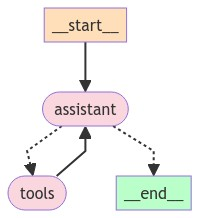

In [82]:
from IPython.display import Image, display

try:
    display(Image(yomap_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [83]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Puedes decirme las categorias de servicios de la base de datos?",
    "Quienes son los proveedores de servicios de la categoria spa?",
    "Alguno de los proveedores de servicio spa tiene redes sociales?",
    "Cual es la edad promedio de los proveedores de servicio home?",
]

config = {
    "configurable": {
        "user_name": "Noel",
        "thread_id": "1",
    }
}


_printed = set()
for question in tutorial_questions:
    events = yomap_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Puedes decirme las categorias de servicios de la base de datos?
================================== Ai Message ==================================
Tool Calls:
  get_yomap_service_categories (call_e093CAYhApyrsqqdCkXKOOB5)
 Call ID: call_e093CAYhApyrsqqdCkXKOOB5
  Args:


/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


================================= Tool Message =================================
Name: get_yomap_service_categories

["cerrajeria", "piano", "asistente_virtual", "8_56_hierro", "assistant", "tutorias", "muebles", "transporte_de_alimentos", "carrozas", "plomero", "taxi", "tv", "ai", "musica", "depilacion", "llaves_perdidas", "mototaxi", "moda", "asistente", "indriver", "cerrajeria_automotriz", "musica", "nevera", "musico", "piano", "taxi", "ayuda", "aseo", "delivery", "paseo_de_aves", "vegetariano", "health_panama", "iphone", "fisioterapia", "nueva_salud", "costurera", "1", "albanil", "street_food", "masajes", "llaves_para_autos", "yomap", "moto", "uber", "delivery", "manos_y_pies", "marketing", "computadoras", "educacion", "desarrollo_de_software", "portuguese", "pizza", "pet_care", "health", "travel_agency", "transport", "psicopedagoga", "spa", "plantas", "paseo_de_perros", "smartphone", "food", "dog_sitting", "pets", "repair", "home", "misc", "user"]
=================================

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


================================== Ai Message ==================================

Los proveedores de servicios de la categoría "Spa" son:
1. Carolina
2. Angela
3. Emulator 66980917
================================ Human Message =================================

Alguno de los proveedores de servicio spa tiene redes sociales?
================================== Ai Message ==================================
Tool Calls:
  get_profile_info_from_firebase (call_KIHgmNNXOwexRtxvJtw2ot8L)
 Call ID: call_KIHgmNNXOwexRtxvJtw2ot8L
  Args:
    name: Carolina
  get_profile_info_from_firebase (call_sMsmxrzTPtH9Yd52VahwGHS4)
 Call ID: call_sMsmxrzTPtH9Yd52VahwGHS4
  Args:
    name: Angela
  get_profile_info_from_firebase (call_3OhTdVQ5nDOlpFbezGb8FfKI)
 Call ID: call_3OhTdVQ5nDOlpFbezGb8FfKI
  Args:
    name: Emulator 66980917
Carolina
Angela
Emulator 66980917
{'age': '29', 'realTimeLocEnabled': False, 'displayName': 'Carolina', 'tags': [{'text': 'spa', 'weight': 0, 'id': 'jNDxsch7qIDIubx39R1K', 'used

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


================================== Ai Message ==================================

De los proveedores de servicios de la categoría "Spa":
1. **Carolina** tiene redes sociales. Puedes encontrarla en:
   - [Tiktok](https://www.tiktok.com/@fisicamr/video/7304286339388804385)
   - [Instagram](https://instagram.com/tendencia_unas?igshid=OGQ5ZDc2ODk2ZA==)
   - [Facebook](https://m.facebook.com/spamanospty)

2. **Angela** no tiene redes sociales disponibles.
================================ Human Message =================================

Cual es la edad promedio de los proveedores de servicio home?
================================== Ai Message ==================================
Tool Calls:
  get_service_provider_from_firebase (call_znpEaYCcvR8lQ6g5ftBlj0MC)
 Call ID: call_znpEaYCcvR8lQ6g5ftBlj0MC
  Args:
    tag: home
home
================================= Tool Message =================================
Name: get_service_provider_from_firebase

["Akshdeep", "shankar", "joginder singh", "Harpre

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


================================== Ai Message ==================================
Tool Calls:
  get_profile_info_from_firebase (call_sCDMpdFDNDMD57zwGnNcOwLc)
 Call ID: call_sCDMpdFDNDMD57zwGnNcOwLc
  Args:
    name: Akshdeep
  get_profile_info_from_firebase (call_pjxpm54SjAWnm7INWNDPzS08)
 Call ID: call_pjxpm54SjAWnm7INWNDPzS08
  Args:
    name: shankar
  get_profile_info_from_firebase (call_UZlF9URtN9e7pYU8VAKjuFBT)
 Call ID: call_UZlF9URtN9e7pYU8VAKjuFBT
  Args:
    name: joginder singh
  get_profile_info_from_firebase (call_wappCikH9LwGFiRj78AeUr3j)
 Call ID: call_wappCikH9LwGFiRj78AeUr3j
  Args:
    name: Harpreet Singh
  get_profile_info_from_firebase (call_IFxRvRkEKQYmxyKuKLrbVh1Y)
 Call ID: call_IFxRvRkEKQYmxyKuKLrbVh1Y
  Args:
    name: abhi
  get_profile_info_from_firebase (call_oclxLKaa6n8YFPZ5KLPHfEn4)
 Call ID: call_oclxLKaa6n8YFPZ5KLPHfEn4
  Args:
    name: Rutiner Dasheeri
  get_profile_info_from_firebase (call_3qP658fLa8zIRAfux5FOZIJP)
 Call ID: call_3qP658fLa8zIRAfux5FO

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments.

================================== Ai Message ==================================

La edad promedio de los proveedores de servicio "Home" es de aproximadamente 29 años.


In [84]:
memory.get(config)

{'v': 1,
 'ts': '2024-08-13T19:20:43.786945+00:00',
 'id': '1ef59a92-2acc-6d83-8014-974209e32975',
 'channel_values': {'messages': [HumanMessage(content='Puedes decirme las categorias de servicios de la base de datos?', id='a18ac555-1edb-4037-9839-cbcd6d8d46c4'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_e093CAYhApyrsqqdCkXKOOB5', 'function': {'arguments': '{}', 'name': 'get_yomap_service_categories'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-d769edcf-fe74-44ea-af3c-9241e2d67b3c-0', tool_calls=[{'name': 'get_yomap_service_categories', 'args': {}, 'id': 'call_e093CAYhApyrsqqdCkXKOOB5'}]),
   ToolMessage(content='["cerrajeria", "piano", "asistente_virtual", "8_56_hierro", "assistant", "tutorias", "muebles", "transporte_de_alimentos", "carrozas", "plomero", "taxi", "tv", "ai", "musica", "depilacion", "llaves_perdidas", "mototaxi", "moda", "asistente", "indriver", "cerraje

In [85]:
yomap_graph.invoke(
    {
        "messages": (
            "user",
            "cuales son los rating de los proveedores de servicio home, ignora aquellos que no tengan rating",
        )
    },
    config=config,
)

Akshdeep
shankar
joginder singh
Harpreet Singh
abhi
Rutiner Dasheeri
Navratan Singh
Test user 63636363
Kuldeep Singh
Test Real Number Colombia
Millycen Hurtado
{'age': 15, 'tags': [{'text': 'home', 'weight': 0, 'id': '5QOMIURL9xYnZgPWSSIp', 'usedBy': 12, 'parentSlug': '', 'parentId': '', 'slug': 'home'}], 'displayName': 'Akshdeep', 'commentsCount': 0, 'realTimeLocEnabled': False, 'network': [], 'rating': 0, 'about': '', 'socialNetworks': [], 'userId': 'Ie6f50w1oEMfqVAMNjRg7sfr3wp2', 'totalRatingVotes': 0, 'blockedProfiles': [], 'service': {'text': 'home', 'weight': 0, 'id': '5QOMIURL9xYnZgPWSSIp', 'usedBy': 12, 'parentSlug': '', 'parentId': '', 'slug': 'home'}, 'address': '32WC+X3W, 32WC+X3W, Sudan, Punjab, India', 'gender': 'male', 'photo': '', 'location': <google.cloud.firestore_v1._helpers.GeoPoint object at 0x7f33cb5e2b10>}
{'age': 19, 'tags': [{'text': 'home', 'weight': 0, 'id': '5QOMIURL9xYnZgPWSSIp', 'usedBy': 12, 'parentSlug': '', 'parentId': '', 'slug': 'home'}], 'displayName'

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments.

{'age': 35, 'tags': [{'text': 'home', 'weight': 0, 'id': '5QOMIURL9xYnZgPWSSIp', 'usedBy': 10, 'parentSlug': '', 'parentId': '', 'slug': 'home'}, {'text': 'delivery', 'weight': 0, 'id': 'CXPoHI4OBLhWyVMVXZbG', 'usedBy': 1, 'parentSlug': 'home', 'parentId': '5QOMIURL9xYnZgPWSSIp', 'slug': 'delivery'}], 'displayName': 'Test Real Number Colombia', 'commentsCount': 0, 'realTimeLocEnabled': False, 'network': [], 'rating': 0, 'about': '', 'socialNetworks': [], 'userId': 'cIjJSUsgCsatULoVK9hiAYZYuxS2', 'totalRatingVotes': 0, 'blockedProfiles': [], 'service': {'text': 'home', 'weight': 0, 'id': '5QOMIURL9xYnZgPWSSIp', 'usedBy': 10, 'parentSlug': '', 'parentId': '', 'slug': 'home'}, 'address': 'Vía Ricardo Joaquin Alfaro, Vía Ricardo Joaquin Alfaro, Panama City, Panamá, Panama', 'gender': 'female', 'photo': '', 'location': <google.cloud.firestore_v1._helpers.GeoPoint object at 0x7f33cb5c0990>}


{'messages': [HumanMessage(content='Puedes decirme las categorias de servicios de la base de datos?', id='a18ac555-1edb-4037-9839-cbcd6d8d46c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_e093CAYhApyrsqqdCkXKOOB5', 'function': {'arguments': '{}', 'name': 'get_yomap_service_categories'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-d769edcf-fe74-44ea-af3c-9241e2d67b3c-0', tool_calls=[{'name': 'get_yomap_service_categories', 'args': {}, 'id': 'call_e093CAYhApyrsqqdCkXKOOB5'}]),
  ToolMessage(content='["cerrajeria", "piano", "asistente_virtual", "8_56_hierro", "assistant", "tutorias", "muebles", "transporte_de_alimentos", "carrozas", "plomero", "taxi", "tv", "ai", "musica", "depilacion", "llaves_perdidas", "mototaxi", "moda", "asistente", "indriver", "cerrajeria_automotriz", "musica", "nevera", "musico", "piano", "taxi", "ayuda", "aseo", "delivery", "paseo_de_aves", "vegetaria

In [48]:
yomap_graph.invoke(
    {"messages": ("user", "cuales son los servicios que no tienen proveedores")},
    config=config,
)

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments.

cerrajeria
piano
asistente_virtual
8_56_hierro
assistant
tutorias
muebles
transporte_de_alimentos
carrozas
plomero
taxi
tv
ai
musica
depilacion
llaves_perdidas
mototaxi
moda
asistente
indriver
cerrajeria_automotriz
nevera
musico
piano
taxi
ayuda
aseo
delivery
paseo_de_aves
health_panama
vegetariano
iphone
fisioterapia
nueva_salud
costurera
1
albanil
street_food
masajes
llaves_para_autos
yomap
moto
uber
delivery
manos_y_pies
marketing
computadoras
educacion


/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments.

desarrollo_de_software
portuguese
pizza
pet_care
health
travel_agency
transport
psicopedagoga
spa
plantas
paseo_de_perros
smartphone
food
dog_sitting
pets
repair
home
misc
user


/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments.

{'messages': [HumanMessage(content='Puedes decirme las categorias de servicios de la base de datos?', id='c9a65b75-8f0f-4312-8d61-ffb1bba52963'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_IR048XZbgAhPLe7sGyZWw7rM', 'function': {'arguments': '{}', 'name': 'get_yomap_service_categories'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ad53aee6-e3b4-4b68-83bd-7726717b4eb3-0', tool_calls=[{'name': 'get_yomap_service_categories', 'args': {}, 'id': 'call_IR048XZbgAhPLe7sGyZWw7rM'}]),
  ToolMessage(content='["cerrajeria", "piano", "asistente_virtual", "8_56_hierro", "assistant", "tutorias", "muebles", "transporte_de_alimentos", "carrozas", "plomero", "taxi", "tv", "ai", "musica", "depilacion", "llaves_perdidas", "mototaxi", "moda", "asistente", "indriver", "cerrajeria_automotriz", "musica", "nevera", "musico", "piano", "taxi", "ayuda", "aseo", "delivery", "paseo_de_aves", "vegetaria

In [88]:
events = yomap_graph.invoke(
    {
        "messages": (
            "user",
            "Podrias buscarme la info de los proveedores de servicio spa",
        )
    },
    config=config,
)

Carolina
Angela
Emulator 66980917
{'age': '29', 'realTimeLocEnabled': False, 'displayName': 'Carolina', 'tags': [{'text': 'spa', 'weight': 0, 'id': 'jNDxsch7qIDIubx39R1K', 'usedBy': 0, 'parentSlug': '', 'parentId': '', 'slug': 'spa'}, {'text': 'manos_y_pies', 'weight': 0, 'id': 'NjIAAjPlxDpQFsTTlHvp', 'usedBy': 1, 'parentSlug': 'spa', 'parentId': 'jNDxsch7qIDIubx39R1K', 'slug': 'manos_y_pies'}, {'text': 'depilacion', 'weight': 0, 'id': 'KENplKSXBIS9D6K4I2g0', 'usedBy': 0, 'parentSlug': 'spa', 'parentId': 'jNDxsch7qIDIubx39R1K', 'slug': 'depilacion'}], 'network': ['SWnS77x57jRDQ7UnFhpz', 'ZXeLeERP2v9n3HEMCL6c'], 'avgRating': 4.5, 'about': 'nails design and care . artista manicura:  bodas, shows, pellculas. Premiada', 'socialNetworks': [{'url': 'https://www.tiktok.com/@fisicamr/video/7304286339388804385', 'name': 'Tiktok'}, {'url': 'https://instagram.com/tendencia_unas?igshid=OGQ5ZDc2ODk2ZA==', 'name': 'Instagram'}, {'url': 'https://m.facebook.com/spamanospty', 'name': 'Facebook'}], 'use

/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/home/nmlemus/projects/ai-llm/.conda/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:302: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


In [89]:
_print_event(events, _printed)

================================== Ai Message ==================================

La información de los proveedores de servicio "Spa" es la siguiente:
1. **Carolina**:
   - Edad: 29 años
   - Rating promedio: 4.5
   - Descripción: Diseño y cuidado de uñas. Artista de manicura para bodas, shows y películas. Premiada.
   - Redes sociales:
     - [Tiktok](https://www.tiktok.com/@fisicamr/video/7304286339388804385)
     - [Instagram](https://instagram.com/tendencia_unas?igshid=OGQ5ZDc2ODk2ZA==)
     - [Facebook](https://m.facebook.com/spamanospty)
   - Dirección: 3602, Nicanor de Obarrio O 4ta Sur, Panamá, Provincia de Panamá, Panamá
   - Total de opiniones: 6
   - Ubicación: Latitud 8.9790422, Longitud -79.5279649
   - ![Foto de perfil](Files/Users/kJxLOBl87FbWJhmVIOPac3bHSeY2/file_1720458441813-157994_Screenshot_2022-02-14-17-46-04-448_com.google.android.googlequicksearchbox.jpg)

2. **Emulator 66980917**:
   - Edad: 32 años
   - No se encontró más información disponible.
